# Imports & Global Arguments

In [1]:
import os
import json
import time

In [2]:
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from rouge_score import rouge_scorer
from bert_score import score

from transformers import AutoModelForCausalLM, AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from datasets import Dataset

nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /home/maxim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/maxim/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
PROJECT_ROOT_PATH = os.path.expanduser("~")
DRYAD_DATASET_PATH = os.path.join(PROJECT_ROOT_PATH, "assets", "rsos_dream_data.tsv")
DREAM_DATASET_PATH = os.path.join(PROJECT_ROOT_PATH, "assets", "dream_train.json")

INTERPRET_DREAM_QUERY_TEMPLATE = "Interpret this dream: %s"

MAX_TEXT_INPUT_LENGTH = 512
MAX_TEXT_OUTPUT_LENGTH = 512

FLAN_T5_SMALL_NAME = "google/flan-t5-small"
FLAN_T5_SMALL_FINE_TUNED_DIR = os.path.join(PROJECT_ROOT_PATH, "assets", "flan_t5_small_fine_tuned")
FLAN_T5_SMALL_FINE_TUNE_LOGS = os.path.join(PROJECT_ROOT_PATH, "assets", "flan_t5_small_fine_tune_logs")

GPT2_SMALL_NAME = "gpt2"
GPT2_SMALL_FINE_TUNED_DIR = os.path.join(PROJECT_ROOT_PATH, "assets", "gpt2_small_fine_tuned")
GPT2_SMALL_FINE_TUNE_LOGS = os.path.join(PROJECT_ROOT_PATH, "assets", "gpt2_small_fine_tune_logs")

# Datasets Init

## Freud Interpret

In [4]:
freud_dataset_raw = {
  "I was walking across a narrow bridge high above a canyon when suddenly the ground beneath me gave way. I felt myself plummeting into the abyss, unable to grab onto anything to stop my fall.": "This dream represents fears of losing control in a critical situation. The unstable bridge could symbolize fragile confidence or an uncertain path in waking life, while the fall reflects anxieties about failing to maintain stability or achieve a desired outcome.",
  "I was climbing a steep mountain, desperately trying to reach the top, but my grip slipped, and I tumbled down, feeling a sense of dread and helplessness as I fell further and further away from the summit.": "This dream symbolizes fear of failure or setbacks in achieving ambitious goals. The mountain represents aspirations, while the fall may indicate a perceived inability to meet expectations or maintain progress in waking life.",
  "I was flying through the sky, feeling free and weightless, but suddenly I began to fall. The ground came rushing toward me, and no matter how much I tried, I couldn’t stop myself from crashing.": "This dream reflects a fear of losing control after experiencing success or freedom. The fall represents anxieties about an imminent failure or the inability to sustain the elevated state of achievement in waking life.",
  "I was standing on a crowded train platform, waiting for my train, when I suddenly realized I wasn’t wearing any clothes. Everyone around me started staring and whispering, and I felt frozen, unable to cover myself or escape.": "This dream symbolizes feelings of vulnerability and being judged by others. The crowded platform represents a social situation where the dreamer may feel exposed or unprepared, reflecting anxieties about public perception or criticism in waking life.",
  "I was giving a presentation in front of my colleagues, feeling confident, until I looked down and saw that I was completely naked. The room erupted in laughter, and I felt a wave of shame and panic.": "This dream reflects fear of exposure or inadequacy in a professional setting. The nakedness signifies a fear of being unprepared or having personal flaws revealed in front of others, especially in a situation requiring confidence or competence.",
  "I was walking through a busy city street, surrounded by strangers, when I noticed I had no clothes on. No one seemed to care or notice, but I felt deeply embarrassed and tried to hide behind objects as I moved.": "This dream suggests feelings of self-consciousness and a heightened sense of exposure, even when others may not be paying attention. It reflects an internal struggle with insecurity and the dreamer’s fear of being noticed or judged.",
  "I found myself soaring over a dense forest, the treetops stretching endlessly below me. The wind rushed past my face, and I felt an incredible sense of freedom, as if nothing in the world could hold me back.": "This dream symbolizes a deep desire to escape from life’s constraints or responsibilities. The act of flying over the forest suggests a longing to rise above challenges or break free from situations that feel overwhelming or restrictive in waking life.",
  "I was flying above a vast ocean, skimming the waves with my fingertips. The water sparkled under the sunlight, and I felt light and unburdened, as if all my worries had been left behind on the shore.": "This dream represents a yearning for emotional freedom and relief from stress. The ocean often symbolizes the subconscious, and flying over it suggests the dreamer’s wish to transcend deep-seated fears or emotional burdens, seeking liberation and peace.",
  "I was running through a crowded city, feeling trapped by the chaos, when suddenly I lifted off the ground and flew above the buildings. From above, everything seemed calm, and I felt a sense of control and clarity I hadn’t felt in a long time.": "This dream reflects a desire to escape the pressures of daily life. The crowded city symbolizes stress or societal demands, while flying represents the dreamer’s wish to gain a new perspective and freedom from those constraints, reclaiming a sense of control.",
  "I was talking to a friend when I suddenly felt a strange looseness in my mouth. One by one, my teeth began falling out into my hands. I tried to speak, but my words came out garbled, and my friend just stared at me in shock.": "This dream represents anxiety about communication—the inability to speak properly may symbolize a fear of saying the wrong thing or being misunderstood in waking life. It may also reflect social insecurities, particularly about how others perceive the dreamer.",
  "I was looking in the mirror, brushing my teeth, when I noticed they were crumbling like sand. No matter how much I tried to hold them together, they kept falling apart, leaving me feeling helpless and horrified.": "This dream is associated with worries about appearance and self-image. The crumbling teeth may symbolize a fear of aging, losing attractiveness, or feeling powerless over changes in one’s life. It could also reflect a loss of confidence or fear of personal deterioration.",
  "I was in an important meeting at work, speaking confidently, when I suddenly felt my teeth becoming loose. As I kept talking, they started falling out onto the table. I tried to cover my mouth, but everyone had already noticed": "This dream reflects performance anxiety and fear of public embarrassment. It suggests the dreamer may feel insecure about their professional abilities or worry about being judged by colleagues. Losing teeth in front of others can symbolize a fear of losing credibility or respect in a social or work-related environment.",
  "I dreamed that I was attending my own funeral, watching from a distance as people I knew gathered to say goodbye. Strangely, I didn’t feel scared—just calm, as if I were preparing to leave behind an old version of myself": "This dream symbolizes a major life transition or personal transformation. Attending one’s own funeral often represents letting go of the past, shedding old habits, or embracing a new phase in life. It may reflect a psychological rebirth, where the dreamer is moving beyond an old identity or way of living.",
  "I dreamed that a close friend passed away. I was devastated, but then I saw them again, alive and different somehow—like they had changed into someone new.": "This dream is not necessarily about literal death but rather about change. The death of a friend in a dream may indicate that the relationship itself is evolving, or that the dreamer sees a change in the friend’s personality or role in their life. It could also represent fears of losing connection with them.",
  "I was walking through an old house when I stumbled upon a grave with my childhood name on it. I stood there, realizing that the person I used to be no longer existed.": "This dream suggests a symbolic death of the past self. The grave with a childhood name represents growing up, maturing, or leaving behind past behaviors. It may indicate a moment of self-realization where the dreamer acknowledges personal growth or a shift in identity.",
  "I was sitting in a huge exam hall, staring at a test paper filled with questions I had never seen before. No matter how hard I tried to answer, my mind went blank. The clock was ticking loudly, and I could feel panic rising as time slipped away.": "This dream reflects anxiety about performance and judgment. The inability to answer the questions suggests the dreamer may feel unprepared or inadequate in some aspect of their waking life—whether at work, in relationships, or in personal expectations.",
  "I arrived at school, realizing I had completely forgotten about an important final exam. I frantically searched for a pen, but every time I found one, it wouldn’t write. The teacher glared at me as I struggled, feeling helpless and embarrassed.": "This dream represents fear of failure and a lack of control. The forgotten exam may symbolize unconscious self-doubt, while the inability to write can reflect a fear of being powerless or incapable in a real-life situation where the dreamer feels pressured to perform well.",
  "I was taking a test in a subject I had never studied, but strangely, I felt calm. As I flipped through the pages, I realized the questions were about my own life—decisions I had made, relationships I had built. The answers were not right or wrong, only reflections of my past choices.": "This dream suggests self-evaluation and introspection rather than external pressure. Instead of fearing judgment, the dreamer may be going through a phase of self-reflection, questioning past decisions and considering how they have shaped their present reality.",
  "I was running through a dark forest, my heart pounding as something unseen chased me. No matter how fast I ran, I could hear footsteps closing in behind me. I tried to scream, but no sound came out, and I felt completely powerless.": "This dream represents avoidance of a deep-seated fear or unresolved issue in waking life. The unknown pursuer could symbolize anxiety, guilt, or a problem the dreamer is trying to escape rather than confront. The inability to scream suggests feelings of helplessness or repression.",
  "A masked figure was chasing me through a city. I darted through alleyways and hid behind cars, but no matter where I went, they always found me. Just as they reached out to grab me, I woke up in a panic.": "This dream may reflect stress or pressure from an external force—such as work, relationships, or responsibilities that feel overwhelming. The masked figure could symbolize an unknown fear or a situation the dreamer is trying to avoid, but it keeps resurfacing.",
  "I was being chased by a wild animal, running as fast as I could. Just before it caught me, I turned around and realized the animal was no longer there—I had been running from nothing.": "This dream suggests that the dreamer may be running from an imagined or exaggerated fear. It could indicate unnecessary worry or avoidance of an issue that is not as dangerous as it seems. Facing the fear directly may bring relief in waking life.",
  "I was standing on the edge of a skyscraper, looking down at the city below. Suddenly, the ground beneath me crumbled, and I began to fall. My arms flailed, but there was nothing to hold onto. As I plummeted, my stomach dropped, and I felt completely powerless, knowing there was no way to stop myself from hitting the ground.": "This dream symbolizes a fear of losing control in an important aspect of life—whether in career, relationships, or personal stability. The high place represents ambition or success, while the fall reflects anxieties about failing or losing everything. It may also indicate a fear of uncertainty or instability, suggesting that the dreamer feels overwhelmed by circumstances beyond their control.",
  "I was walking into a classroom filled with students when I suddenly realized I wasn’t wearing any clothes. My heart pounded as I tried to cover myself with my hands, but everyone was staring at me. Some laughed, while others just looked at me with confusion. I wanted to run, but my feet wouldn’t move.": "This dream reflects anxiety about judgment and self-image, particularly in academic or social settings. The classroom suggests a fear of intellectual or personal inadequacy, while the inability to escape may indicate feeling trapped in a situation where the dreamer fears being exposed as unprepared or incapable.",
  "I wasl at a wedding, surrounded by elegantly dressed guests, when I looked down and saw that I was completely naked. No one seemed to notice at first, but as I tried to act normal, whispers and shocked glances spread through the crowd. My face burned with embarrassment as I searched for something to cover myself.": "This dream suggests a fear of not meeting social expectations or feeling out of place in formal or high-pressure environments. Weddings often symbolize life transitions, so the nakedness could indicate anxiety about a major change in the dreamer’s personal or social life, such as commitment, relationships, or status.",
  "I was giving a speech at a large event, feeling confident at first, until I noticed people in the audience giggling. When I looked down, I realized I was wearing nothing. I tried to continue speaking, but the more I spoke, the louder the laughter became, until I could barely hear myself.": "This dream represents performance anxiety and fear of public humiliation. The act of giving a speech symbolizes self-expression or professional exposure, while the laughter from the audience suggests a deep-seated fear of criticism or being unprepared in a crucial moment. It may indicate self-doubt in professional or social settings.",
  "I was running through a field when suddenly my feet lifted off the ground. I soared higher and higher, feeling weightless as I glided over the landscape. The sky was bright and endless, and I felt an incredible sense of freedom, as if I had escaped all my worries.": "This dream symbolizes a deep longing for freedom and escape from life’s burdens. The effortless flight represents a desire to break free from stress, responsibilities, or emotional constraints. It may indicate a need to step back from daily pressures and regain a sense of control.",
  "I was trapped inside a dark, windowless room, struggling to find a way out. Just as I was about to give up, I felt my body become lighter, and I floated toward the ceiling. I passed through the walls and into the open sky, leaving the darkness behind.": "This dream reflects a need for escape from a restrictive situation. The dark room symbolizes feeling trapped—either emotionally, mentally, or in a real-life circumstance. Flying away represents breaking free from limitations, whether they be personal, professional, or psychological.",
  "I was flying over an ocean, the waves shimmering below me as the wind carried me effortlessly. But as I tried to go higher, something invisible pulled me back down, making it harder and harder to stay in the air.": "This dream represents an internal conflict between the desire for freedom and external forces holding the dreamer back. The ocean can symbolize the subconscious mind or emotional depth, while the struggle to fly higher suggests real-life obstacles—such as responsibilities, fears, or doubts—that prevent full liberation.",
  "I was flying over a city at night, watching the streets and buildings below. I felt powerful, like I could go anywhere, but I realized I was alone. There was no one else flying with me, and I suddenly felt disconnected from the world below.": "This dream suggests a sense of independence and control but also isolation. The ability to fly symbolizes personal empowerment and self-sufficiency, while the loneliness may indicate feeling detached from others due to personal ambitions or life changes. It may suggest a need to balance independence with connection.",
  "I was in the middle of a heated argument when, suddenly, I pushed off the ground and flew away. As I soared above the situation, the shouting faded, and I felt an overwhelming sense of relief.": "This dream symbolizes a strong desire to avoid confrontation or escape emotional conflicts. Flying away represents removing oneself from a stressful or negative situation rather than facing it directly. It may indicate a tendency to disengage from problems instead of resolving them.",
  "I was laughing with a group of people when I suddenly felt something strange in my mouth. I reached in and pulled out a loose tooth, but as soon as I did, more teeth started falling out one by one. I tried to hide it, but everyone noticed and looked horrified.": "This dream symbolizes anxiety about social perception and self-image. The dreamer may feel insecure about how others see them, particularly in social or professional settings. It could also indicate a fear of embarrassment or saying the wrong thing in an important situation.",
  "I was chewing on something when I suddenly realized my teeth were crumbling into tiny pieces. No matter how much I tried to spit them out, more and more broke apart, until my entire mouth felt empty and powerless.": "This dream reflects a feeling of losing control or power in communication. The act of chewing suggests an attempt to process or handle a situation, but the crumbling teeth indicate a fear of being unable to express oneself effectively or feeling weak in a certain aspect of life.",
  "I looked in the mirror and noticed my teeth were rotting and falling out. I tried to push them back in, but they kept slipping through my fingers. My reflection looked older and unfamiliar, and I felt a wave of panic.": "This dream represents fears related to aging, self-worth, and appearance. The mirror and the decaying teeth may indicate anxiety about physical deterioration, attractiveness, or self-confidence. It could also symbolize feeling unable to stop an inevitable change in life.",
  "I was about to give a speech in front of a large audience when my teeth started to loosen. As I spoke, they fell out onto the podium one by one. I tried to keep talking, but my voice became distorted, and people in the audience began whispering and laughing.": "This dream suggests a fear of public speaking, performance anxiety, or communication failure. Losing teeth while speaking may reflect a deep concern about being judged, misunderstood, or saying something embarrassing. It could also indicate a fear of losing authority or credibility in a situation where the dreamer wants to be taken seriously.",
  "I was on a date with someone I really liked, feeling confident, when suddenly I felt my teeth becoming loose. I tried to keep smiling and talking, but they started falling out into my hand. My date looked disgusted, and I wanted to disappear.": "This dream represents insecurities in romantic or personal relationships. It may indicate a fear of rejection, not being good enough, or feeling exposed in front of someone important. The teeth falling out symbolize a loss of confidence and control in an intimate or vulnerable situation.",
  "I dreamed that my childhood home was being demolished, and as I stood there watching, I saw my younger self inside, waving goodbye before disappearing in the dust. I felt a strange mix of sadness and relief.": "This dream symbolizes the end of a significant life phase and personal transformation. The destruction of the childhood home represents leaving behind old identities, memories, or past attachments, while the younger self waving suggests acknowledging growth and moving forward.",
  "I was walking through a cemetery when I found a gravestone with my name on it. Instead of feeling afraid, I felt peaceful, as if I was ready to move on to something new. Flowers were growing around the grave, and the air felt fresh and light.": "This dream represents acceptance of change and renewal. Seeing one’s own gravestone can symbolize the end of an old version of the self—whether it’s a mindset, habit, or life stage. The peaceful feeling and flowers suggest growth, transformation, and a positive transition into something new.",
  "I dreamed that I was on a sinking ship, struggling to stay afloat. As the water rose, I panicked, but then I suddenly stopped fighting and let myself sink. Instead of drowning, I found myself in a completely new place, as if I had been reborn.": "This dream symbolizes letting go of control and embracing change. The sinking ship represents a part of life that is ending or no longer serving the dreamer, while the transition to a new place suggests a transformation or a fresh start in waking life.",
  "I was attending a funeral for someone I didn’t know, but when I looked inside the casket, I saw a version of myself lying there. Strangely, I felt no fear—just a quiet understanding that something in my life had come to an end.": "This dream suggests a deep personal transformation or shedding of an old identity. Seeing oneself in a casket can represent leaving behind outdated beliefs, behaviors, or past experiences. The calmness in the dream indicates that the dreamer is subconsciously ready for this transition.",
  "I dreamed that a close friend died, and I was devastated. But later in the dream, I saw them again—alive, but different somehow. They looked older, wiser, and distant, as if they had moved on from our friendship.": "This dream may not be about literal death but rather a changing relationship. The death of a friend in a dream can symbolize the evolution or fading of a connection. Seeing them “reborn” as someone different suggests subconscious recognition that the dynamic of the relationship is shifting or that the dreamer is growing apart from them.",
  "I arrived at an exam hall, but when I looked at the paper, the questions were in a language I didn’t understand. The professor stood over me, waiting for me to write something, but I felt frozen, unable to make sense of a single word.": "This dream represents a fear of being unprepared or feeling out of place in a high-pressure situation. The unfamiliar language symbolizes a lack of confidence or knowledge in a specific area of waking life, possibly in a job, relationship, or personal expectation.",
  "I was taking a math test, but no matter how hard I tried, I couldn’t solve a single problem. My pencil kept breaking, the numbers blurred on the page, and the more I panicked, the faster the clock ticked down.": "This dream reflects performance anxiety and a fear of failure. Math often represents logic and problem-solving, so the inability to answer questions may indicate stress about decision-making or feeling mentally overwhelmed in real life.",
  "I walked into a classroom only to realize I had missed the entire semester and now had to take the final exam. My classmates looked at me with pity as I flipped through the test paper, completely lost.": "This dream suggests feelings of inadequacy, imposter syndrome, or guilt about not meeting expectations. It may stem from a fear of being exposed as unprepared or lacking the necessary skills in an important aspect of life.",
  "I was taking an exam, but instead of using a pen, I had to answer aloud in front of a huge audience. Every time I got a question wrong, the crowd would laugh, and I felt smaller and smaller, as if I might disappear.": "This dream symbolizes fear of public embarrassment or social judgment. The exam represents self-evaluation, while the audience reflects external pressures or criticism in real life—perhaps from work, family, or peers.",
  "I finally finished an impossible exam and felt relieved—only to have the teacher hand me another test, even harder than the last. No matter how many I completed, they just kept coming, and I realized I would never be done.": "This dream reflects a feeling of constant pressure or never being ‘good enough’. It suggests that the dreamer may feel like no matter how much they accomplish, new challenges always arise, leading to exhaustion and stress.",
  "I was running through an empty shopping mall, chased by a shadowy figure. No matter which store I ran into or how many turns I took, the figure was always just behind me. When I finally turned around to confront it, I woke up.": "This dream suggests a subconscious avoidance of a fear or unresolved issue. The shadowy figure may represent a hidden anxiety, past mistake, or responsibility that the dreamer has been trying to ignore. The inability to escape could indicate a need to finally confront the problem.",
  "I was being chased by a pack of wild dogs through a narrow alley. Their growls got louder as they got closer, and I could feel my heart pounding. Just as they were about to catch me, I found a door and slammed it shut behind me.": "This dream may symbolize overwhelming stress, pressure, or aggression in waking life. The dogs could represent hostile people, demanding responsibilities, or personal fears that feel uncontrollable. Closing the door suggests a temporary escape, but the unresolved fear may still be present.",
  "I was walking home when I noticed someone following me. No matter how fast I walked, they stayed the same distance behind me. I never saw their face, but I knew they were always there, just out of sight.": "This dream represents a lingering fear or unresolved issue that the dreamer cannot escape. The faceless pursuer may symbolize a hidden worry, guilt, or responsibility that follows the dreamer in waking life, even when they try to ignore it.",
  "I was running from a giant wave crashing behind me. No matter how fast I ran, the water kept getting closer, and I knew I couldn’t outrun it. Just before it hit me, I woke up.": "This dream suggests feeling overwhelmed by emotions, stress, or an unavoidable life event. The wave could symbolize suppressed feelings, anxiety, or external pressures that the dreamer is trying to avoid but knows they must eventually face.",
  "I was being chased through a dark forest by a version of myself—only this version looked angry and determined. Every time I tried to hide, it found me. It felt like I was running from my own reflection.": "This dream symbolizes inner conflict and self-avoidance. Being chased by oneself may indicate denying an aspect of one’s personality, emotions, or past actions. It suggests that the dreamer needs to confront their own thoughts, feelings, or decisions rather than running from them."
}
freud_df = pd.DataFrame(list(freud_dataset_raw.items()), columns=["dream_description", "dream_interpretation"])
print(freud_df.head(2))


                                   dream_description  \
0  I was walking across a narrow bridge high abov...   
1  I was climbing a steep mountain, desperately t...   

                                dream_interpretation  
0  This dream represents fears of losing control ...  
1  This dream symbolizes fear of failure or setba...  


### What is Freud Interpret?
This is a manually generated dataset of 50 dreams. They are associated with the common Freud interpretations:
* Dreams about falling: Often related to fears of losing control or failing.
* Dreams about being naked in public: Can represent feelings of vulnerability or exposure.
* Dreams about flying: May symbolize a desire for freedom or escape from constraints.
* Dreams about teeth falling out: Could represent anxiety about appearance or communication.
* Dreams about death: Often symbolic of change or transition rather than literal death.
* Dreams about exams or tests: May reflect feelings of being judged or evaluated in waking life.
* Dreams about being chased: Could represent avoiding a problem or fear in waking life.

The dataset has no additional data. This is intended to ensure the research of how well models trained on the following datasets cope with unseen, "raw" dreams and custom interpretations, i.e. by Freud rules.

## Dryad

In [5]:
dryad_df = pd.read_csv(DRYAD_DATASET_PATH, sep='\t')
print(dryad_df.head(2))

   dream_id dreamer               description dream_date dream_language  \
0         1    alta  Alta: a detailed dreamer       1957             en   
1         2    alta  Alta: a detailed dreamer  8/11/1967             en   

                                          text_dream  \
0  The one at the Meads's house, where it's bigge...   
1  I'm at a family reunion in a large fine house ...   

                characters_code emotions_code  aggression_code  \
0  2ISA, 1MKA, 1FDA, 1IOA, 2ISA           NaN         2IKA > Q   
1            2ISA, people, 2ISA       SD 2IKA  D > Q, Q > 2ISA   

  friendliness_code  ... Male  Animal  Friends  Family  Dead&Imaginary  \
0         2IKA 4> Q  ...  0.5     0.0      0.2     0.2             0.0   
1               NaN  ...  0.0     0.0      0.0     0.0             0.0   

   Aggression/Friendliness  A/CIndex  F/CIndex  S/CIndex  NegativeEmotions  
0                      0.0  0.200000       0.2       0.0               0.0  
1                      1.0  0

### What is Dryad dataset?
["Our Dreams, Our Selves: Automatic Interpretation of Dream Reports"](https://datadryad.org/stash/dataset/doi:10.5061/dryad.qbzkh18fr) dataset comprises over 20,000 dream reports sourced from https://dreambank.net. It is well-suited for Natural Language Processing tasks, particularly in the realm of automated text analysis and classification:
* Identify Characters: Detect and classify entities within dream narratives.
* Analyze Interactions: Determine the nature of interactions (e.g., friendly, aggressive, sexual) between characters.
* Assess Emotional Tone: Evaluate the emotional content and sentiment expressed in the text.

The automated text analysis and classification provides a "logical bridge" to Freud dream analysis, which can be outlined as follows:
1. Train the model on Dryad dataset.
2. "Translate" dreams from "Freud Interpret" dataset to Dryad encoding format.
3. Further train the model with the combined input of 40 "Freud Interpret" dream description, associated Dryad encoding format and expected output of Freud interpretation.
4. Validate the model on the rest of the 10 "Freud Interpret" dreams

## DREAM

In [6]:
dream_dataset_raw = None
with open(DREAM_DATASET_PATH, "r") as a_file:
  dream_dataset_raw = json.load(a_file)
dream_df_rows_raw = []
for an_item in dream_dataset_raw:
  a_dialogue = " ".join(an_item[0])
  for a_question_item in an_item[1]:
    a_question = a_question_item["question"]
    multiple_choices = a_question_item["choice"]
    an_answer = a_question_item["answer"]
    dream_df_rows_raw.append({
      "dialogue": a_dialogue,
      "question": a_question,
      "multiple_choice": multiple_choices,
      "correct_answer": an_answer
    })
dream_df = pd.DataFrame(dream_df_rows_raw)
print(dream_df.head(2))

                                            dialogue  \
0  M: I am considering dropping my dancing class....   
1  W: Well, I'm afraid my cooking isn't to your t...   

                                          question  \
0          What does the man suggest the woman do?   
1  What does the man think of the woman's cooking?   

                                     multiple_choice  \
0  [Consult her dancing teacher., Take a more int...   
1  [It's really terrible., It's very good indeed....   

                correct_answer  
0  Continue her dancing class.  
1       It's very good indeed.  


### What is DREAM dataset?
[DREAM](https://dataset.org/dream/) is a multiple-choice Dialogue-based REAding comprehension exaMination dataset. It's data can be examined at [official repository](https://github.com/nlpdata/dream/tree/master/data).

Dialogue presents an outstanding dataset trait, which presents a significant challenge for nowadays LLMs. The prediction of correct asnwer inherently requires from a model to "reason" beyond the standard approach of `next 1 or 2 words prediction` even when concept of "attention" is utilized.

Which is what makes this dataset a suitable train source for our task at hand. Mapping dreams to Freud interpretations is inherently more complicated than a naive classification combined with prediction of the next `N` words. There is a requirement to "reason" about interpretation with a dream's summary "in mind".

# Models Choice

## Flan-T5-Small
[Google's Flan-T5-Small](https://huggingface.co/google/flan-t5-small) is the first model choice, which will be trained on the "Dryad" dataset. This is a "light" version of [Google's T5-large](https://huggingface.co/google-t5/t5-large).

The motivation is T5 specializing at [Transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). According to the [official accompanying paper](https://jmlr.org/papers/volume21/20-074/20-074.pdf), we assume that the model is expected to sort of "gracefully translate" a dream's summary to a Freud interpretation. The underlying principle in T5 is the treatment of every text processing problem as a "text-to-text" problem. Which suits our task at hand.

Translation is not the only model's strong trait. It also specializes at abstract summariztion, unlike its counterparts from BERT family.

The secondary reasoning for choosing Flan-T5-Small is our computational resources. The research is conducted on Macbook Pro M1 machine, which has modest graphical processing capabilities.

## GPT-2 Small
[GPT2 Small](https://huggingface.co/docs/transformers/en/model_doc/gpt2) is the second model choice, primarily given the industry wide success of [OpenAI](https://openai.com) in complicated human level tasks, like dream interpretation.

As with the previous model, GPT2 Small is a lightweight counterpart of GPT-2 (a predecessor to the famous GPT-3) that fits our local computational environment.

# Ruled out models
## DistilBERT
[DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) is a "light" version of [BERT](https://arxiv.org/abs/1810.04805).

The motivation behind the light version is computational environment constraints, similar to motivation behind Flan-T5-Small.

More important though, is the fact that "BERT" is sort of an alternative strategy to "T5-large". It is designed to pretrain deep bidirectional representations. This makes it a perfect candidate for question answering and language inference with just an additional single layer during fine-tuning. However, it works by filling in MASK values - whereas our goal is to generate entire sequences based on the input context.

## TinyLlama/TinyLlama-1.1B-Chat-v1.0
[TinyLlama/TinyLlama-1.1B-Chat-v1.0](https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0) is a "light" version of [LLaMA](https://huggingface.co/docs/transformers/en/model_doc/llama). While it is similar in its operation to "T5", even the light version did not terminate generation on our computational environment of a single output.

# Research question
We would like to measure models' performance on the Freud dream interpretation task with the following metrics:
* BLEU
* ROUGE
* Perplexity
* BERT score

Our expected observations are two-fold.  
First, both models are expected to perform poorly on the Freud dataset. This is because of an inherent low probability that their training involved such a specific task. However, there is an option that Freud interpretation system itself was actually covered, thanks to the vast data volume used during both models' training.  
Still, we expect a poor performance. Especially in regard of metrics like BLEU, because our Freud interpretations are custom. Their exact formulation must be novel to each model.

In any case, the first observation of metrics will be treated as a baseline.

Our final observation is expected to see the improvement in each metric. This is because of the "fine-tuning" that each model will go through based on our dream datasets.

# Metrics

In [12]:
def plot_metrics(metrics_df):
  score_names = ["bleu", "rouge", "perplexity", "bert_score"]
  
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))
  
  row0 = metrics_df.iloc[0]
  values = [row0[col] for col in score_names]
  axes[0, 0].bar(score_names, values, color=["blue", "red", "green", "purple"])
  axes[0, 0].set_title(f"Metrics of {row0['model_name']}")
  axes[0, 0].set_ylabel("Normalized Score")

  row1 = metrics_df.iloc[1]
  values = [row1[col] for col in score_names]
  axes[0, 1].bar(score_names, values, color=["blue", "red", "green", "purple"])
  axes[0, 1].set_title(f"Metrics of {row1['model_name']}")
  axes[0, 1].set_ylabel("Normalized Score")

  models = [row0["model_name"], row1["model_name"]]
  execution_times = [row0["execution_time_in_seconds"], row1["execution_time_in_seconds"]]
  axes[1, 0].bar(models, execution_times, color=["orange", "cyan"])
  axes[1, 0].set_title("Freud dataset: %s VS %s runtime" % (row0["model_name"], row1["model_name"]))
  axes[1, 0].set_ylabel("Execution Time (seconds)")
  axes[1, 1].axis("off")

  plt.tight_layout()
  plt.show()

## Bilingual Evaluation Understudy (BLEU)
This is a cumulative representation of precision in `N-gram` overlaps between expected and actual output.

In [13]:
def calculate_bleu(the_device, the_model, the_tokenizer, test_df):
  bleu_scores = []
  for _, a_row in test_df.iterrows():
    input_text = INTERPRET_DREAM_QUERY_TEMPLATE % a_row["dream_description"]
    reference = [word_tokenize(a_row["dream_interpretation"])] # preserves punctuation tokens
    inputs = the_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=MAX_TEXT_INPUT_LENGTH).to(the_device)
    smoothing = SmoothingFunction().method1 # keeps meaningful score when output is too short, i.e. not a single 2-gram matche exists
    with torch.no_grad(): # memory usage, inference speed, and accidental gradien updates are improved by disabling gradient computation
      output_ids = the_model.generate(**inputs, max_length=MAX_TEXT_OUTPUT_LENGTH)
      generated_text = the_tokenizer.decode(output_ids[0], skip_special_tokens=True)
      candidate = word_tokenize(generated_text)
      bleu = sentence_bleu(reference, candidate, smoothing_function=smoothing)
      bleu_scores.append(bleu)
    
  avg_bleu = sum(bleu_scores) / len(bleu_scores)
  return avg_bleu

## Recall-Oriented Understudy for Gisting Evaluation (ROUGE)
This is a family of metrics that evaluates an existing overlap between the expected and actual output.

`ROUGE-L` is to be used, which operates on `N-grams` (similar to `BLEU`). "L" stands for the longest sequence match.  
`ROUGE` concentrates on recall, while `BLEU` concentrates on precision.  
The former captures the amount of expected output captured in the actual output, while the later measures the exact `N-gram` matches.

In [14]:
def calculate_rouge_l(the_device, the_model, the_tokenizer, test_df):
  rouge_scores = []
  scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
  for _, a_row in test_df.iterrows():
    input_text = INTERPRET_DREAM_QUERY_TEMPLATE % a_row["dream_description"]
    reference = a_row["dream_interpretation"]
    inputs = the_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=MAX_TEXT_INPUT_LENGTH).to(the_device)
    with torch.no_grad():
      output_ids = the_model.generate(**inputs, max_length=MAX_TEXT_OUTPUT_LENGTH)
      generated_text = the_tokenizer.decode(output_ids[0], skip_special_tokens=True)
      # the difference with BLEU is the absence of exact tokenization match, which is why "word_tokenize" is skipped here.
      rouge_score = scorer.score(reference, generated_text)["rougeL"].fmeasure
      rouge_scores.append(rouge_score)
  return sum(rouge_scores) / len(rouge_scores)

## Perplexity
This is a metric that measures entropy in a model when generating a text. It operates on the probability distribution over the words in a sentece. Which is a different approach compared to `BLEU` and `ROUGE`.

The min and max perplexity value will be used, to normalize the score that originally is in rage of 1 to infinity.

In [15]:
def calculate_perplexity(the_device, the_model, the_tokenizer, test_df):
  perplexities = []
  the_model.to(the_device)
  the_model.eval()
  for _, a_row in test_df.iterrows():
    input_text = INTERPRET_DREAM_QUERY_TEMPLATE % a_row["dream_description"]
    tokens = the_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=MAX_TEXT_INPUT_LENGTH).to(the_device)
    with torch.no_grad():
      outputs = the_model(**tokens, labels=tokens["input_ids"])
      loss = outputs.loss
      perplexity = torch.exp(loss)
      perplexities.append(perplexity.item())

  min_ppl, max_ppl = min(perplexities), max(perplexities)
  normalized_ppl_scores = [(max_ppl - p) / (max_ppl - min_ppl) for p in perplexities]  
  return sum(normalized_ppl_scores) / len(normalized_ppl_scores)

## BERT score
This is yet another type of metric that differs from `BLEU`, `ROUGE`, and `Perplexity`.

It measures the semantic similarities between expected and actual output.

In [16]:
def calculate_bert_score(the_model, the_tokenizer, test_df):
  references = test_df["dream_interpretation"].tolist()
  candidates = []
  for _, a_row in test_df.iterrows():
    input_text = INTERPRET_DREAM_QUERY_TEMPLATE % a_row["dream_description"]
    inputs = the_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=MAX_TEXT_INPUT_LENGTH)
    with torch.no_grad():
      output_ids = the_model.generate(**inputs, max_length=MAX_TEXT_OUTPUT_LENGTH)
      generated_text = the_tokenizer.decode(output_ids[0], skip_special_tokens=True)
      candidates.append(generated_text)

  P, R, F1 = score(candidates, references, lang="en", model_type="microsoft/deberta-xlarge-mnli")

  return F1.mean().item()  # Return the average BERTScore (F1)

# Models Init

In [17]:
current_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Flan-T5-Small

In [13]:
t5_tokenizer = T5Tokenizer.from_pretrained(FLAN_T5_SMALL_NAME)
t5_model = T5ForConditionalGeneration.from_pretrained(FLAN_T5_SMALL_NAME)
t5_model.to(current_device)
print(f"{FLAN_T5_SMALL_NAME} model loaded on {current_device}")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


google/flan-t5-small model loaded on cpu


## GPT-2 Small

In [14]:
gpt2_tokenizer = AutoTokenizer.from_pretrained(GPT2_SMALL_NAME)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = AutoModelForCausalLM.from_pretrained(GPT2_SMALL_NAME)
gpt2_model.eval()
print(f"{GPT2_SMALL_NAME} model loaded on {current_device}")

gpt2 model loaded on cpu


# Baseline performance

In [15]:
baseline_df = pd.DataFrame(columns=["model_name", "bleu", "rouge", "perplexity", "bert_score", "execution_time_in_seconds"])

## Flan-T5-Small

In [16]:
t5_baseline_row = {
  "model_name": FLAN_T5_SMALL_NAME,
  "bleu": None,
  "rouge": None,
  "perplexity": None,
  "bert_score": None,
  "execution_time_in_seconds": None
}
start_time = time.time()
t5_baseline_row["bleu"] = "%.4f" % calculate_bleu(current_device, t5_model, t5_tokenizer, freud_df)
t5_baseline_row["rouge"] = "%.4f" % calculate_rouge_l(current_device, t5_model, t5_tokenizer, freud_df)
t5_baseline_row["perplexity"] = "%.4f" % calculate_perplexity(current_device, t5_model, t5_tokenizer, freud_df)
t5_baseline_row["bert_score"] = "%.4f" % calculate_bert_score(t5_model, t5_tokenizer, freud_df)
end_time = time.time()
t5_baseline_row["execution_time_in_seconds"] = "%.4f" % (end_time - start_time)

baseline_df.loc[baseline_df.shape[0]] = t5_baseline_row

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


{'model_name': 'google/flan-t5-small', 'bleu': '0.0031', 'rouge': '0.0889', 'perplexity': '0.7565', 'bert_score': '0.5149', 'execution_time_in_seconds': '189.8859'}


## GPT-2 Small

In [17]:
gpt_baseline_row = {
  "model_name": GPT2_SMALL_NAME,
  "bleu": None,
  "rouge": None,
  "perplexity": None,
  "bert_score": None,
  "execution_time_in_seconds": None
}
start_time = time.time()
gpt_baseline_row["bleu"] = "%.4f" % calculate_bleu(current_device, gpt2_model, gpt2_tokenizer, freud_df)
gpt_baseline_row["rouge"] = "%.4f" % calculate_rouge_l(current_device, gpt2_model, gpt2_tokenizer, freud_df)
gpt_baseline_row["perplexity"] = "%.4f" % calculate_perplexity(current_device, gpt2_model, gpt2_tokenizer, freud_df)
gpt_baseline_row["bert_score"] = "%.4f" % calculate_bert_score(gpt2_model, gpt2_tokenizer, freud_df)
end_time = time.time()
gpt_baseline_row["execution_time_in_seconds"] = "%.4f" % (end_time - start_time)

baseline_df.loc[baseline_df.shape[0]] = gpt_baseline_row

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

## Observation
We can conclude that baseline `Flan-T5-Small` model is the optimal among the two. Purely from technical perspective.

Both `GPT2 Small` and `Flan-T5-Small` have poor scores. Which is no surprise, as we can't assume that their pre-training involved Freud dream interpretation with the custom formulation that is present in our Freud dataset.

That being said, `Flan-T5-Small` significantly outperforms its counterpart in terms of execution speed.

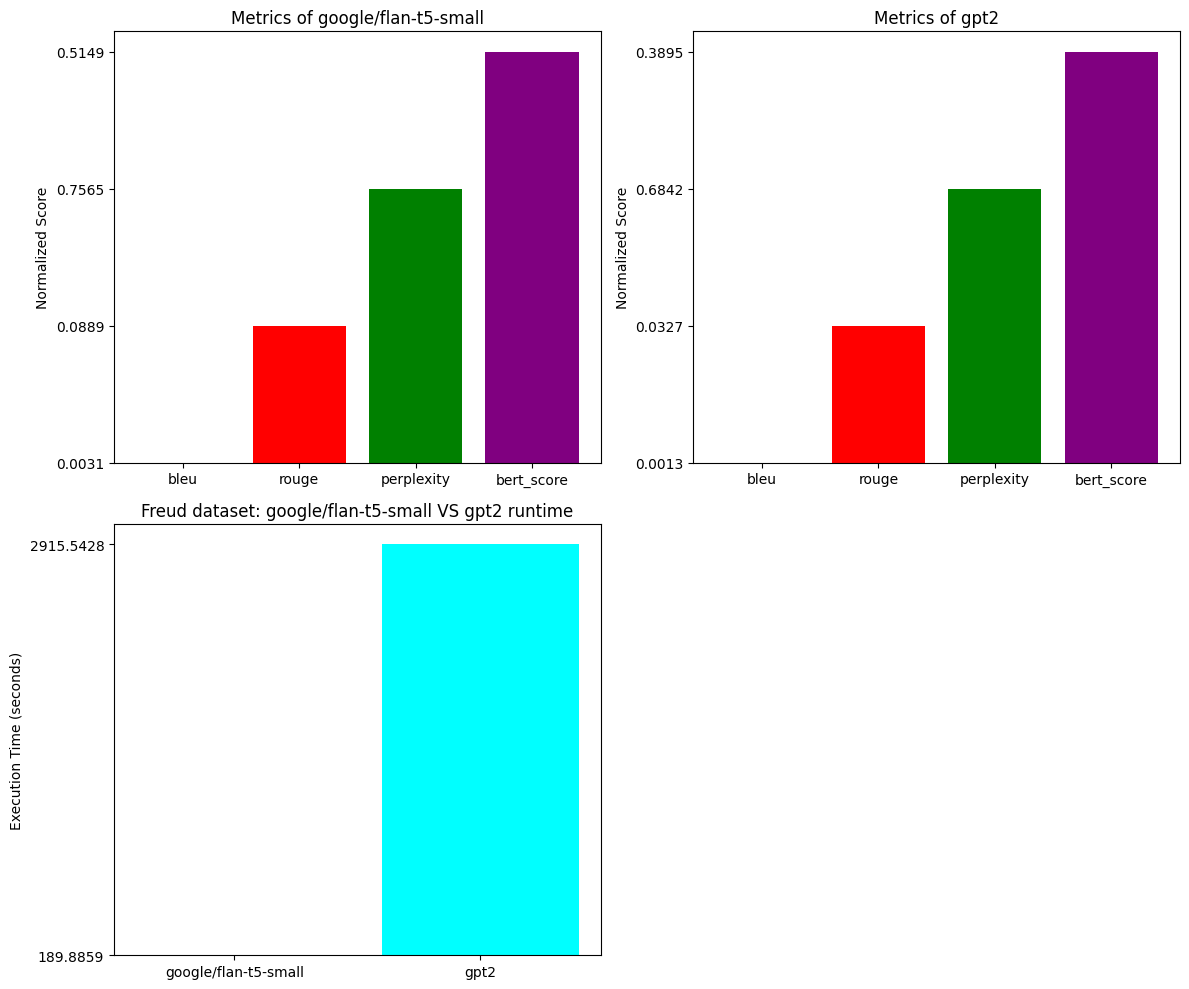

In [18]:
plot_metrics(baseline_df)

# Fine-tune

In [5]:
def fine_tune_a_model(model_name, the_model, the_tokenizer, original_df):
  if model_name == FLAN_T5_SMALL_NAME:
    fine_tune_dataset = init_t5_fine_tune_hugging_face_dataset(the_tokenizer, original_df)
  else:
    fine_tune_dataset = init_gpt2_fine_tune_hugging_face_dataset(the_tokenizer, original_df)

  output_dir = FLAN_T5_SMALL_FINE_TUNED_DIR if model_name == FLAN_T5_SMALL_NAME else GPT2_SMALL_FINE_TUNED_DIR
  logging_dir = FLAN_T5_SMALL_FINE_TUNE_LOGS if model_name == FLAN_T5_SMALL_NAME else GPT2_SMALL_FINE_TUNE_LOGS
  training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=1,
    logging_dir=logging_dir,
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True if torch.cuda.is_available() else False # use mixed precision if available
  )
  trainer = Trainer(
    model=the_model,
    args=training_args,
    train_dataset=fine_tune_dataset["train"],
    eval_dataset=fine_tune_dataset["test"],
    tokenizer=the_tokenizer
  )
  trainer.train()

## Flan-T5-Small

In [6]:
def init_t5_fine_tune_hugging_face_dataset(the_tokenizer, original_df):
  fine_tune_df = original_df.drop(columns=["dream_id", "dreamer"]).dropna()
  fine_tune_df = fine_tune_df.astype(str)
  fine_tune_data = {
    "input": [INTERPRET_DREAM_QUERY_TEMPLATE % text for text in fine_tune_df["text_dream"]],
    "target": [
      " | ".join([f"{col}: {row[col]}" for col in fine_tune_df.columns if col != "text_dream"]) for _,row in fine_tune_df.iterrows()
    ]
  }
  fine_tune_dataset = Dataset.from_dict(fine_tune_data)
  fine_tune_dataset = fine_tune_dataset.train_test_split(test_size=0.2)
  
  def tokenize_data(example):
    input_ids = the_tokenizer(
      example["input"],
      padding="max_length",
      truncation=True,
      max_length=MAX_TEXT_INPUT_LENGTH,
      return_tensors="pt"
    )["input_ids"]
    labels = the_tokenizer(
      example["target"],
      padding="max_length",
      truncation=True,
      max_length=MAX_TEXT_OUTPUT_LENGTH,
      return_tensors="pt"
    )["input_ids"]
    return {"input_ids": input_ids, "labels": labels}
  
  return fine_tune_dataset.map(tokenize_data, batched=True)

In [21]:
if not os.listdir(FLAN_T5_SMALL_FINE_TUNED_DIR):
  fine_tune_a_model(FLAN_T5_SMALL_NAME, t5_model, t5_tokenizer, dryad_df)
  t5_model.save_pretrained(FLAN_T5_SMALL_FINE_TUNED_DIR)
  t5_tokenizer.save_pretrained(FLAN_T5_SMALL_FINE_TUNED_DIR)

Map:   0%|          | 0/2483 [00:00<?, ? examples/s]

Map:   0%|          | 0/621 [00:00<?, ? examples/s]

/home/maxim/.local/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1633/573310012.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.235300,1.781293


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


In [7]:
t5_tokenizer = T5Tokenizer.from_pretrained(FLAN_T5_SMALL_FINE_TUNED_DIR)
t5_model = T5ForConditionalGeneration.from_pretrained(FLAN_T5_SMALL_FINE_TUNED_DIR)

## GPT2-Small

In [8]:
def init_gpt2_fine_tune_hugging_face_dataset(the_tokenizer, original_df):
  fine_tune_df = original_df.astype(str)
  
  inputs = []
  targets = []
  for _, row in fine_tune_df.iterrows():
    inputs.append("Dialogue: %s Question: %s Possible Answers: %s What is the correct answer?" % (
      row['dialogue'],
      row['question'],
      row['multiple_choice']
    ))
    targets.append(row["correct_answer"])
  fine_tune_data = {"input": inputs, "target": targets}
  
  fine_tune_dataset = Dataset.from_dict(fine_tune_data)
  fine_tune_dataset = fine_tune_dataset.train_test_split(test_size=0.2)
  
  def tokenize_data(example):
    inputs = the_tokenizer(example["input"], padding="max_length", truncation=True, max_length=MAX_TEXT_INPUT_LENGTH)
    labels = the_tokenizer(example["target"], padding="max_length", truncation=True, max_length=MAX_TEXT_OUTPUT_LENGTH)
    return {
      "input_ids": inputs["input_ids"],
      "attention_mask": inputs["attention_mask"],
      "labels": labels["input_ids"]
    }
  
  return fine_tune_dataset.map(tokenize_data, batched=True)

In [23]:
if not os.listdir(GPT2_SMALL_FINE_TUNE_LOGS):
  fine_tune_a_model(GPT2_SMALL_NAME, gpt2_model, gpt2_tokenizer, dream_df)
  gpt2_model.save_pretrained(GPT2_SMALL_FINE_TUNED_DIR)
  gpt2_tokenizer.save_pretrained(GPT2_SMALL_FINE_TUNED_DIR)

Map:   0%|          | 0/4892 [00:00<?, ? examples/s]

Map:   0%|          | 0/1224 [00:00<?, ? examples/s]

/home/maxim/.local/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1633/573310012.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.065600,0.065404


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
gpt2_tokenizer = AutoTokenizer.from_pretrained(GPT2_SMALL_NAME)
gpt2_model = AutoModelForCausalLM.from_pretrained(GPT2_SMALL_NAME)
gpt2_model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# Fine tuned performance

In [10]:
fine_tuned_df = pd.DataFrame(columns=["model_name", "bleu", "rouge", "perplexity", "bert_score", "execution_time_in_seconds"])

## Flan-T5-Small

In [18]:
t5_fine_tuned_row = {
  "model_name": FLAN_T5_SMALL_NAME,
  "bleu": None,
  "rouge": None,
  "perplexity": None,
  "bert_score": None,
  "execution_time_in_seconds": None
}
start_time = time.time()
t5_fine_tuned_row["bleu"] = "%.4f" % calculate_bleu(current_device, t5_model, t5_tokenizer, freud_df)
t5_fine_tuned_row["rouge"] = "%.4f" % calculate_rouge_l(current_device, t5_model, t5_tokenizer, freud_df)
t5_fine_tuned_row["perplexity"] = "%.4f" % calculate_perplexity(current_device, t5_model, t5_tokenizer, freud_df)
t5_fine_tuned_row["bert_score"] = "%.4f" % calculate_bert_score(t5_model, t5_tokenizer, freud_df)
end_time = time.time()
t5_fine_tuned_row["execution_time_in_seconds"] = "%.4f" % (end_time - start_time)

fine_tuned_df.loc[fine_tuned_df.shape[0]] = t5_fine_tuned_row

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


## GPT2 Small

In [19]:
gpt_fine_tuned_row = {
  "model_name": GPT2_SMALL_NAME,
  "bleu": None,
  "rouge": None,
  "perplexity": None,
  "bert_score": None,
  "execution_time_in_seconds": None
}
start_time = time.time()
gpt_fine_tuned_row["bleu"] = "%.4f" % calculate_bleu(current_device, gpt2_model, gpt2_tokenizer, freud_df)
gpt_fine_tuned_row["rouge"] = "%.4f" % calculate_rouge_l(current_device, gpt2_model, gpt2_tokenizer, freud_df)
gpt_fine_tuned_row["perplexity"] = "%.4f" % calculate_perplexity(current_device, gpt2_model, gpt2_tokenizer, freud_df)
gpt_fine_tuned_row["bert_score"] = "%.4f" % calculate_bert_score(gpt2_model, gpt2_tokenizer, freud_df)
end_time = time.time()
gpt_fine_tuned_row["execution_time_in_seconds"] = "%.4f" % (end_time - start_time)

fine_tuned_df.loc[fine_tuned_df.shape[0]] = gpt_fine_tuned_row

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

## Observation
We observe:
- a slight, `0.0012`, improvement in the `BLEU` score for `Flan-T5-Small` and no change for `GPT2-Small`.
- a slight, `~0.01`, decrease in the `ROUGE` score for `Flan-T5-Small` and no change for `GPT2-Small`.
- a slight, `~0.05`, improvement in the `Perplexity` score for `Flan-T5-Small` and no change for `GPT2-Small`.
- a slight, `~0.002`, improvement in the `BERT Score` for `Flan-T5-Small` and no change for `GPT2-Small`.

In terms of runtime, `Flan-T5-Small` outpaces `GPT2-Small` with a significant difference.  
The runtime for `Flan-T5-Small` after fine tuning increased by `~300` seconds; while `GPT2-Small` stayed approximately the same.



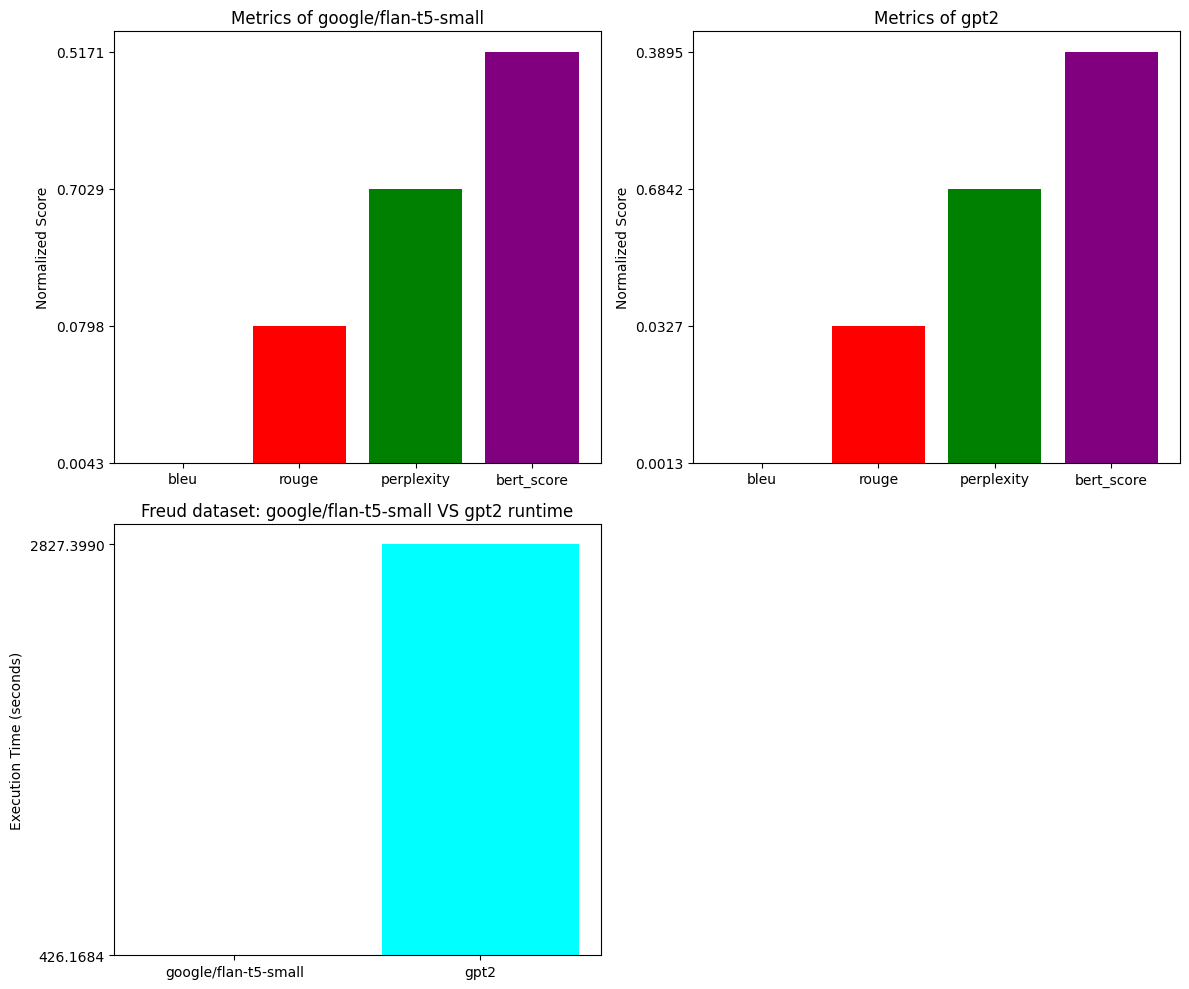

In [20]:
plot_metrics(fine_tuned_df)

# Conclusion
Our project measured the performance of `Flan-T5-Small` and `GPT2-Small` models on interpretation of dreams with primary Freud categories.

The measurements were done before and after models' fine tuning on different datasets.  
`Flan-T5-Small` was fine tuned on the `Dryad` dataset and `GPT2-Small` on the `DREAM`.

The observed baseline performance for the both models was low, as expected. The chance that they were pretrained with Freud dream interpretation "in mind" was low. The chance that they were pretrained with dream descriptions and their interpretations meeting our custom formulation was even lower.

Post fine-tuning performance showed a slight improvement for `Flan-T5-Small` and no change for `GPT2-Small`. This was not in line with our initial expectations.

Examinig the process in the hindsight - we can point out a number of aspects that explain post fine-tuning performance:
- Computational environment is modest. Mac Book Pro M1 that was used is suitable for "light models" only, which may not have sufficient physical memory to capture necessary relations for a meaningful, correct interpretation of a dream. The task goes beyond simple classification - it requires a generation of an explanation.
- Number of epochs should havemore than 1, i.e. 5 (which is commonly used). Building on our previous point, the computational resources were not enough to go beyond a single epoch. Which may be insufficient to capture the relationships described above.
- `Dryad` formulation is "far from" manual `Freud` dataset. It uses a different system that relies on shortcuts and coding symbols, which may contribute little to a model in "translation" of a dream description to Freud interpretation.
- `DREAM` doesn't involve enough dialogues about dreams and questions related to their interpretation. In addition, no change in `GPT2-Small` performance hints that this dataset was already used by model's original authors.